In [ ]:
#mockup
import pickle
import numpy as np
import pandas as pd

with open("DatosCompletos.pkl", 'rb') as archivo:
            data = pickle.load(archivo)


In [ ]:
df=data
df = df.drop(columns=[col for col in df.columns if col.endswith('_Time')])
df['group'] = df['condition'].apply(lambda x: 'PD' if x == "Parkinson's" 
                                          else ('HC' if x == 'Healthy' 
                                          else 'DD'))
custom_mapping = {'HC': 0, 'PD': 1, 'DD': 2}
df['group'] = df['group'].map(custom_mapping)
df_final=df.drop(columns=['resource_type', 'study_id', 'condition', 'disease_comment','age_at_diagnosis'])
df = df.drop(columns=['id', 'resource_type', 'study_id', 'condition', 'disease_comment','age_at_diagnosis'])

In [ ]:
df_cuestionario=df.iloc[:, :39]
df_series=df.iloc[:, 38:]
df_final = df_final.iloc[:, [0] + list(range(39, df_final.shape[1]))]

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['group'])
y = df['group']
train_val_idx, test_idx = train_test_split(
    X.index,
    test_size=0.1,
    random_state=7,
    stratify=y  # aquí group debe tener mismo índice que X
)

# Luego split de entrenamiento y validación, también estratificando
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.1,
    random_state=7,
    stratify=y.loc[train_val_idx]  # ¡importante!
)

#X_train = X.loc[train_idx]
#X_val = X.loc[val_idx]
#X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_val = y.loc[val_idx]
y_test = y.loc[test_idx]
y_train_val = y.loc[train_val_idx]

## Cuestionario

In [ ]:
#cuestionario
import pickle
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


categorical_columns = df_cuestionario.columns[3:8]
df_no_series = pd.get_dummies(df_cuestionario, columns=categorical_columns,drop_first=True)

if 'group' in df_no_series.columns:
    X = df_no_series.drop(columns=['group'])
    y = df_no_series['group']
else:
    print("'group' no se encuentra en el DataFrame.")

X_train = X.loc[train_idx]
X_train_val = X.loc[train_val_idx]
X_test = X.loc[test_idx]
X_val = X.loc[val_idx]

# Inicializar modelo Random Forest con parámetros
best_rf = RandomForestClassifier(n_estimators=100,max_depth=None,min_samples_split=2,max_features=None,random_state=7)

# Entrenar el modelo para obtener la importancia de las características
best_rf.fit(X_train, y_train)

# Convertir numéricos mal cargados para el Xgboost
for col in ['age', 'weight']:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_train_val[col] = pd.to_numeric(X_train_val[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Convertir valores 'True'/'False' en texto a 1/0 para el Xgboost
X_train2 = X_train.replace({'True': 1, 'False': 0})
X_train_val2 = X_train_val.replace({'True': 1, 'False': 0})
X_test2 = X_test.replace({'True': 1, 'False': 0})
X_val2 = X_val.replace({'True': 1, 'False': 0})

# Inicializar modelo Xgboost con parámetros
best_xgb = XGBClassifier(objective='multi:softmax',num_class=3,eval_metric='mlogloss',use_label_encoder=False,colsample_bytree=1,learning_rate=0.1,max_depth=3,n_estimators=100,subsample=0.8,random_state=7)

# Entrenar el modelo para obtener importancia de las variables
best_xgb.fit(X_train2, y_train)

# Obtenemos importancia del modelo Random Forest 
importances_rf = best_rf.feature_importances_
var_imp_rf = pd.DataFrame({
    'variable': X.columns,
    'importance_rf': importances_rf
}).sort_values(by='importance_rf', ascending=False).reset_index(drop=True)
var_imp_rf['rank_rf'] = var_imp_rf.index + 1

# Obtenemos importancia del modelo XGBoost
importances_xgb = best_xgb.feature_importances_
var_imp_xgb = pd.DataFrame({
    'variable': X.columns,
    'importance_xgb': importances_xgb
}).sort_values(by='importance_xgb', ascending=False).reset_index(drop=True)
var_imp_xgb['rank_xgb'] = var_imp_xgb.index + 1

# Unir ambas tablas de importancias por variable 
final_res = pd.merge(var_imp_rf, var_imp_xgb, on='variable')

# Calcular diferencia de ranking 
final_res['rank_diff'] = final_res['rank_rf'] - final_res['rank_xgb']

# Ordenar en la tabla por importancia media 
final_res['mean_importance'] = (final_res['importance_rf'] + final_res['importance_xgb']) / 2
final_res = final_res.sort_values(by='mean_importance', ascending=False).reset_index(drop=True)

# Seleccionar las variables basadas en el umbral de importancia media en ambos modelos
umbral = 0.018
selected_vars = final_res.loc[final_res['mean_importance'] > umbral, 'variable'].tolist()
print("Variables seleccionadas:", selected_vars)

# Filtrar los conjuntos de datos para usar únicamente las variables seleccioandas
X_train_filtered = X_train[selected_vars]
X_test_filtered = X_test[selected_vars]
X_train_val_filtered = X_train_val[selected_vars]

Variables seleccionadas: ['age', '02', 'height', 'weight', '08', '25', '01', '09', '05', 'gender_male', 'appearance_in_first_grade_kinship_True', '12', '03', '22', '21', 'effect_of_alcohol_on_tremor_Unknown', '07', '06', 'handedness_right', '13', '15', '26']


No path specified. Models will be saved in: "AutogluonModels/ag-20250507_142245"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:12 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8103
CPU Count:          8
Memory Avail:       1.80 GB / 8.00 GB (22.4%)
Disk Space Avail:   6.39 GB / 228.27 GB (2.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration

F1 Score test: 0.6971884498480244


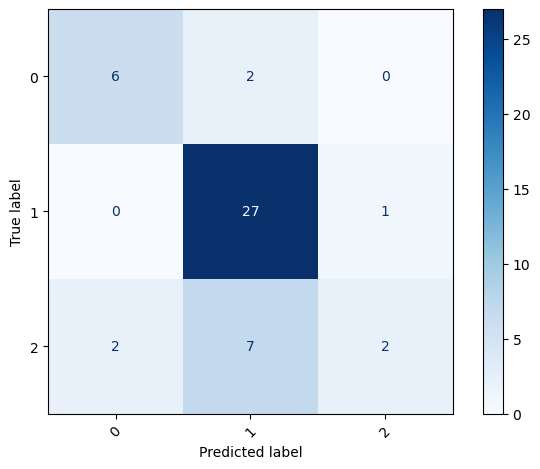

In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# AutoGluon requiere que el target esté en el DataFrame
train_val_data = X_train_val_filtered.copy()
train_val_data['group'] = y_train_val  # asegúrate de que 'group' sea el nombre de la variable target

test_data = X_test_filtered.copy()
test_data['group'] = y_test

# Entrenar AutoML
predictor = TabularPredictor(label='group', eval_metric='f1_weighted').fit(
    train_val_data,
    time_limit=180,  # segundos
    verbosity=2
)

# Predicciones
y_test_pred = predictor.predict(test_data)

f1 = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Score test:", f1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.tight_layout()
plt.show()

# Probabilidades
y_prob_train_cues = predictor.predict_proba(train_val_data)
y_prob_test_cues = predictor.predict_proba(test_data)

In [ ]:
import shap

best_model_name = predictor.model_best
best_model = predictor._trainer.load_model(best_model_name)
X_test_union = test_data.drop(columns=['group'])  
y_test = test_data['group']

def predict_fn(X_array):
    X_df = pd.DataFrame(X_array, columns=X_test_union.columns)
    return predictor.predict_proba(X_df).values  # output: array (n_samples x n_classes)

selected_indices = [347,316,334,245,454,461]

# Asegurarte de que esos índices están en X_test_union
X_background = X_test_union.loc[selected_indices]
# 4. Crear el KernelExplainer
explainer = shap.KernelExplainer(predict_fn, X_background)

# 5. Calcular SHAP values sobre un subconjunto de test (ej: 50 ejemplos)
X_explain = X_test_union.loc[selected_indices]  # Elegí más si tenés tiempo
shap_values = explainer.shap_values(X_explain)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import numpy as np

top_n = 5
n_samples = shap_values.shape[0]
feature_names = X_test_union.columns

top_features_cues = []

for i,e in zip(selected_indices,range(n_samples)):
    pred_class = y_test_pred.loc[i]  # Clase predicha para el individuo i (0, 1 o 2)
    shap_vector = shap_values[e, :, pred_class]  # Vector de 21 SHAP values para la clase predicha

    # Asociar cada SHAP value con su feature name
    df = pd.DataFrame({
        'feature': feature_names,
        'shap_value': shap_vector,
        'abs_shap': np.abs(shap_vector)
    })

    # Elegir top 5 por magnitud
    top_5 = df.sort_values('abs_shap', ascending=False).head(top_n).reset_index(drop=True)

    # Guardar resultados
    top_features_cues.append({
        'patient_index': i,
        'predicted_class': pred_class,
        'top_features': top_5[['feature', 'shap_value']]
    })

In [ ]:
import pandas as pd
import numpy as np

n_samples = shap_values.shape[0]
feature_names = X_test_union.columns

all_features_cues = []

for i, e in zip(selected_indices, range(n_samples)):
    pred_class = y_test_pred.loc[i]  # Clase predicha para el individuo i (0, 1 o 2)
    shap_vector = shap_values[e, :, pred_class]  # Vector de SHAP values para la clase predicha

    # Asociar cada SHAP value con su feature name
    df = pd.DataFrame({
        'feature': feature_names,
        'shap_value': shap_vector,
        'abs_shap': np.abs(shap_vector)
    })

    # Ordenar por magnitud, pero sin filtrar
    sorted_df = df.sort_values('abs_shap', ascending=False).reset_index(drop=True)

    # Guardar todos los resultados ordenados
    all_features_cues.append({
        'patient_index': i,
        'predicted_class': pred_class,
        'all_features': sorted_df[['feature', 'shap_value']]
    })

## BOSS

In [ ]:
# BOSS
from pyts.transformation import BOSS

def apply_boss_to_series(series, boss_model):
    # Aplicar la misma transformación BOSS previamente entrenada
    transformed = boss_model.transform(series.reshape(1, -1)) 
    return transformed[0].toarray()   # Extraemos la primera fila transformada

def train_boss_model(series, window_size=20):
    boss = BOSS(word_size=3, n_bins=4, window_size=window_size, sparse=True)  
    boss.fit(series)  
    return boss  

def transform_dataframe(df, window_size=[20,40,80]):
    df_transformed = df.copy()

    for col in df.columns[1:]:  
        series = np.array(df[col].values.tolist())  
        all_transformed=[]
        
        for w in window_size:
            # Entrenar el modelo BOSS con la serie completa de la columna
            boss_model = train_boss_model(series, w)  
            transformed = df[col].apply(lambda x: apply_boss_to_series(np.array(x), boss_model))
            all_transformed.append(transformed)
        concatenated = [
            np.concatenate([all_transformed[i][j] for i in range(len(all_transformed))])
            for j in range(len(df))
        ]
        df_transformed[col] = concatenated

    return df_transformed


df_BOSS = transform_dataframe(df_series)

In [ ]:
vector_columns = df_BOSS.columns[1:]
expanded_dfs = []

for col in vector_columns:
    # Aplanamos cada fila (3x64) → (192,)
    flattened = df_BOSS[col].apply(lambda x: np.array(x).flatten())
    
    # Creamos nombres de columnas automáticamente según el tamaño real
    vec_length = flattened.iloc[0].shape[0]
    col_names = [f'{col}_vec{i}' for i in range(vec_length)]
    
    expanded = pd.DataFrame(flattened.tolist(), columns=col_names)
    expanded_dfs.append(expanded)

# Concatenamos el grupo (primera columna) con los datos expandidos
df_BOSS_expanded = pd.concat([df_BOSS.iloc[:, :1]] + expanded_dfs, axis=1)

In [ ]:
#_expanded=pd.read_pickle("boss_features.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'boss_features.pkl'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Supongamos que tienes un DataFrame llamado df
# Separamos las características (X) y la etiqueta (y)
X = df_BOSS_expanded.drop(columns=['group'])
y = df_BOSS_expanded['group']

# Dividimos en entrenamiento y prueba
X_train = X.loc[train_idx]
X_val = X.loc[val_idx]
X_test = X.loc[test_idx]
X_train_val = X.loc[train_val_idx]
y_train = y.loc[train_idx]
y_val = y.loc[val_idx]
y_test = y.loc[test_idx]
y_train_val = y.loc[train_val_idx]

# Inicializamos el clasificador Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenamos el modelo para obtener la importancia de las características
model.fit(X_train, y_train)

# Obtenemos la importancia de las características
feature_importances = model.feature_importances_

# Ordenamos las características según la importancia (de mayor a menor)
sorted_idx = np.argsort(feature_importances)[::-1]  # Ordenamos en orden descendente

# Creamos un nuevo DataFrame con las características ordenadas por importancia
X_sorted = X_train.iloc[:, sorted_idx]

# Inicializamos la lista para almacenar el F1-score para diferentes números de características
f1_scores = []

# Número máximo de características a considerar
max_features = len(X_sorted.columns)

# Inicializamos el mejor F1-score y el número de características
best_f1_score = 0
best_n_features = 100

# A partir de las 100 características, vamos añadiendo 10 características más a la vez
X_train_selected = X_sorted.iloc[:, :100]
X_val_selected = X_val.iloc[:, sorted_idx[:100]]

# Entrenamos el modelo con las primeras 100 características
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_val_selected)
best_f1_score = f1_score(y_val, y_pred, average='weighted')
f1_scores.append(best_f1_score)

# Early stopping variables
no_improvement_counter = 0  # Contador de iteraciones sin mejora significativa
max_no_improvement = 6  # Umbral de iteraciones sin mejora
threshold_drop = 0.01  # Umbral para considerar una mejora significativa

# Ahora, vamos a agregar características de 10 en 10
for n_features in range(110, max_features + 1, 10):  # Añadimos de 10 en 10
    # Seleccionamos las primeras n características más importantes
    X_train_selected = X_sorted.iloc[:, :n_features]
    X_val_selected = X_val.iloc[:, sorted_idx[:n_features]]

    # Entrenamos el modelo con las características seleccionadas
    model.fit(X_train_selected, y_train)

    # Realizamos predicciones
    y_pred = model.predict(X_val_selected)

    # Calculamos el F1-score
    f1 = f1_score(y_val, y_pred, average='weighted')  # Usamos 'weighted' para manejar clases desbalanceadas
    f1_scores.append(f1)

    # Si el F1-score no mejora significativamente, incrementamos el contador
    if f1 - best_f1_score < threshold_drop:
        no_improvement_counter += 1
    else:
        no_improvement_counter = 0  # Reseteamos el contador si hay mejora

    # Si el contador de no mejora supera el umbral, detenemos el proceso
    if no_improvement_counter >= max_no_improvement:
        break

    # Actualizamos el mejor F1-score y el número de características si es mejor
    if f1 > best_f1_score:
        best_f1_score = f1
        best_n_features = n_features

# Resultados finales
print(f"\nEl mejor número de características seleccionadas es {best_n_features} con un F1-score de {best_f1_score:.2f}")

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso.fit(X_train, y_train)

selector = SelectFromModel(lasso, prefit=True).set_output(transform="pandas")
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_val)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_test_selected)
f1 = f1_score(y_val, y_pred, average='weighted')
selected_features = X.columns[selector.get_support()]
union_features = sorted(set(selected_features) | set(X_sorted.columns[:best_n_features]))

# Filtramos X_train y X_test usando solo las variables de la unión
X_train_union = X_train[union_features]
X_val_union = X_val[union_features]
X_train_val_union = X_train_val[union_features]
X_test_union = X_test[union_features]


El mejor número de características seleccionadas es 220 con un F1-score de 0.57


No path specified. Models will be saved in: "AutogluonModels/ag-20250507_144731"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:12 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8103
CPU Count:          8
Memory Avail:       1.25 GB / 8.00 GB (15.6%)
Disk Space Avail:   6.31 GB / 228.27 GB (2.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration

F1 Score test: 0.6286704534514297


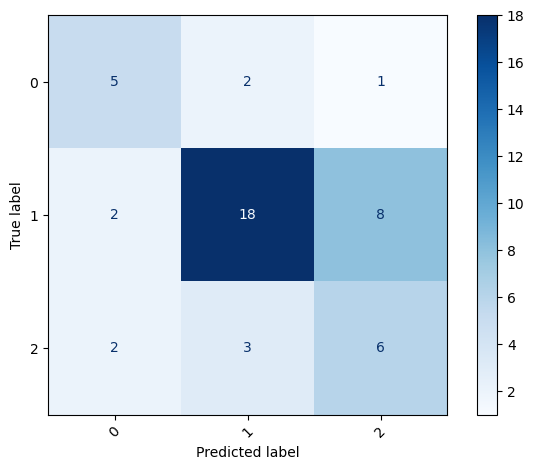

In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# AutoGluon requiere que el target esté en el DataFrame
train_val_data = X_train_val_union.copy()
train_val_data['group'] = y_train_val  # asegúrate de que 'group' sea el nombre de la variable target

test_data = X_test_union.copy()
test_data['group'] = y_test

# Entrenar AutoML
predictor = TabularPredictor(label='group', eval_metric='f1_weighted').fit(
    train_val_data,
    time_limit=220,  # segundos
    verbosity=2
)

# Predicciones
y_test_pred = predictor.predict(test_data)
f1 = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Score test:", f1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.tight_layout()
plt.show()

# Probabilidades
y_prob_train_boss = predictor.predict_proba(train_val_data)
y_prob_test_boss = predictor.predict_proba(test_data)

In [ ]:
import shap

best_model_name = predictor.model_best
best_model = predictor._trainer.load_model(best_model_name)
X_test_union = test_data.drop(columns=['group'])  
y_test = test_data['group']

def predict_fn(X_array):
    X_df = pd.DataFrame(X_array, columns=X_test_union.columns)
    return predictor.predict_proba(X_df).values  # output: array (n_samples x n_classes)

selected_indices = [347,316,334,245,454,461]

# Asegurarte de que esos índices están en X_test_union
X_background = X_test_union.loc[selected_indices]
# 4. Crear el KernelExplainer
explainer = shap.KernelExplainer(predict_fn, X_background)

# 5. Calcular SHAP values sobre un subconjunto de test (ej: 50 ejemplos)
X_explain = X_test_union.loc[selected_indices]  # Elegí más si tenés tiempo
shap_values = explainer.shap_values(X_explain)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import numpy as np

top_n = 5
n_samples = shap_values.shape[0]
feature_names = X_test_union.columns

# Extraer movimientos base (ej: "Rodilla" de "Rodilla x eje_y")
def extract_movement(col_name):
    return col_name.split(' x ')[0] if ' x ' in col_name else col_name

movement_names = [extract_movement(f) for f in feature_names]

top_movements_boss = []

for i,e in zip(selected_indices,range(n_samples)):
    pred_class = y_test_pred.loc[i]  # clase predicha para ese paciente
    shap_vector = shap_values[e, :, pred_class]  # vector de SHAP para la clase predicha

    df = pd.DataFrame({
        'feature': feature_names,
        'movement': movement_names,
        'shap_value': shap_vector,
        'abs_shap': np.abs(shap_vector)
    })

    # Agrupar por movimiento → usar suma o media
    grouped = df.groupby('movement', as_index=False)['abs_shap'].sum()  # o .mean()

    # Top 5 movimientos más importantes
    top_5 = grouped.sort_values('abs_shap', ascending=False).head(top_n).reset_index(drop=True)

    # Guardar resultados
    top_movements_boss.append({
        'patient_index': i,
        'predicted_class': pred_class,
        'top_movements': top_5
    })

In [ ]:
import pandas as pd
import numpy as np

n_samples = shap_values.shape[0]
feature_names = X_test_union.columns

# Extraer movimientos base (ej: "Rodilla" de "Rodilla x eje_y")
def extract_movement(col_name):
    return col_name.split(' x ')[0] if ' x ' in col_name else col_name

movement_names = [extract_movement(f) for f in feature_names]

all_movements_boss = []

for i, e in zip(selected_indices, range(n_samples)):
    pred_class = y_test_pred.loc[i]  # clase predicha para ese paciente
    shap_vector = shap_values[e, :, pred_class]  # vector de SHAP para la clase predicha

    df = pd.DataFrame({
        'feature': feature_names,
        'movement': movement_names,
        'shap_value': shap_vector,
        'abs_shap': np.abs(shap_vector)
    })

    # Agrupar por movimiento → usar suma o media
    grouped = df.groupby('movement', as_index=False)['abs_shap'].sum()  # o .mean()

    # Ordenar todos los movimientos por importancia
    sorted_movements = grouped.sort_values('abs_shap', ascending=False).reset_index(drop=True)

    # Guardar resultados completos
    all_movements_boss.append({
        'patient_index': i,
        'predicted_class': pred_class,
        'all_movements': sorted_movements
    })

## Estadísticos

In [ ]:
#estadisticos
import pandas as pd
import numpy as np
import multiprocessing
import concurrent.futures
import traceback
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# ----- PARTE 1: Extracción de features con tsfresh -----

# Número de series temporales (columnas) a procesar (ajusta según lo que necesites)
num_series = 132

# Obtener el número de núcleos disponibles
n_cores = multiprocessing.cpu_count()

# Diccionario de parámetros para extraer features con tsfresh
custom_fc_parameters = {
    "absolute_sum_of_changes": None,
    "mean": None,
    "median": None,
    "standard_deviation": None,
    "variance": None,
    "skewness": None,
    "kurtosis": None,
    "maximum": None,
    "absolute_maximum": None,
    "first_location_of_maximum": None,
    "first_location_of_minimum": None,
    "last_location_of_maximum": None,
    "last_location_of_minimum": None,
    "sum_values": None,
    "sum_of_reoccurring_data_points": None,
    "range_count": [{"min": 0.5, "max": 2.0}],
    "linear_trend": [
        {"attr": "slope"},
        {"attr": "intercept"},
        {"attr": "rvalue"},
        {"attr": "pvalue"}
    ],
    "fft_coefficient": [
        {"coeff": 0, "attr": "real"},
        {"coeff": 0, "attr": "imag"},
        {"coeff": 1, "attr": "real"},
        {"coeff": 1, "attr": "imag"}
    ],
    "quantile": [{"q": 0.25}, {"q": 0.5}, {"q": 0.75}],
    # En lugar de "q_1" y "q_2", se pasa "q" como tupla
    "autocorrelation": [{"lag": 1}, {"lag": 2}],
    # Se define cid_ce con el parámetro requerido "normalize"
    "cid_ce": [{"normalize": True}],
    "binned_entropy": [{"max_bins": 10}],
    "index_mass_quantile": [{"q": 0.5}],
    "partial_autocorrelation": [{"lag": 1}, {"lag": 2}],
    # Se le suministra un parámetro "r" para symmetry_looking
    "symmetry_looking": [{"r": 0.5}],
    "longest_strike_above_mean": None,
    "longest_strike_below_mean": None,
    # Suministramos el argumento requerido "n" para number_peaks
    "number_peaks": [{"n": 3}]}

def process_series_column(args):
    """
    Extrae las features de una columna de series temporales usando tsfresh.
    Recibe una tupla (col, df_col) donde:
      - col: nombre de la columna.
      - df_col: DataFrame con solo las columnas "id" y la columna de interés.
    """
    col, df_col = args
    try:
        long_df_list = []
        # Convertir cada serie de la columna a formato "long"
        for _, row in df_col.iterrows():
            ts = row[col]
            if isinstance(ts, list) and len(ts) > 0:
                df_long = pd.DataFrame({
                    'id': row['id'],
                    'time': np.arange(len(ts)),
                    'value': ts
                })
                long_df_list.append(df_long)
        if long_df_list:
            df_long_col = pd.concat(long_df_list, ignore_index=True)
            extracted_features = extract_features(
                df_long_col,
                column_id="id",
                column_sort="time",
                column_value="value",
                default_fc_parameters=custom_fc_parameters,
                impute_function=impute,
                n_jobs=1
            )
            extracted_features = extracted_features.add_prefix(f"{col}_")
            return extracted_features
        else:
            return None
    except Exception as e:
        print(f"Error procesando la columna {col}: {e}")
        traceback.print_exc()
        return None

time_series_cols = [col for col in df_final.columns if df_final[col].apply(lambda x: isinstance(x, list)).any()]
print("Columnas de series temporales detectadas (antes de filtrar):", time_series_cols)

time_series_cols = time_series_cols[:num_series]
print(f"Procesando las primeras {num_series} series: {time_series_cols}")

args_list = []
for col in time_series_cols:
    df_col = df_final[['id', col]].copy()
    args_list.append((col, df_col))

with concurrent.futures.ThreadPoolExecutor(max_workers=n_cores) as executor:
    results = list(executor.map(process_series_column, args_list))

features_list = [res for res in results if res is not None]

if features_list:
    ts_features = pd.concat(features_list, axis=1)
    df_final_features = df_final.merge(ts_features, left_on='id', right_index=True, how='left')
    df_final_features = df_final_features.drop(columns=time_series_cols)
else:
    df_final_features = df_final.copy()

df_esta=df_final_features.iloc[:,1:]

Columnas de series temporales detectadas (antes de filtrar): ['Relaxed x LeftWrist_Accelerometer_X', 'Relaxed x LeftWrist_Accelerometer_Y', 'Relaxed x LeftWrist_Accelerometer_Z', 'Relaxed x LeftWrist_Gyroscope_X', 'Relaxed x LeftWrist_Gyroscope_Y', 'Relaxed x LeftWrist_Gyroscope_Z', 'Relaxed x RightWrist_Accelerometer_X', 'Relaxed x RightWrist_Accelerometer_Y', 'Relaxed x RightWrist_Accelerometer_Z', 'Relaxed x RightWrist_Gyroscope_X', 'Relaxed x RightWrist_Gyroscope_Y', 'Relaxed x RightWrist_Gyroscope_Z', 'RelaxedTask x LeftWrist_Accelerometer_X', 'RelaxedTask x LeftWrist_Accelerometer_Y', 'RelaxedTask x LeftWrist_Accelerometer_Z', 'RelaxedTask x LeftWrist_Gyroscope_X', 'RelaxedTask x LeftWrist_Gyroscope_Y', 'RelaxedTask x LeftWrist_Gyroscope_Z', 'RelaxedTask x RightWrist_Accelerometer_X', 'RelaxedTask x RightWrist_Accelerometer_Y', 'RelaxedTask x RightWrist_Accelerometer_Z', 'RelaxedTask x RightWrist_Gyroscope_X', 'RelaxedTask x RightWrist_Gyroscope_Y', 'RelaxedTask x RightWrist_Gyro

Feature Extraction:   0%|          | 0/469 [00:00<?, ?it/s]














Feature Extraction:   0%|          | 1/469 [00:00<01:43,  4.54it/s]
















Feature Extraction:   1%|          | 4/469 [00:00<00:34, 13.46it/s]




















Feature Extraction:   2%|▏         | 8/469 [00:00<00:20, 22.35it/s]




















Feature Extraction:   3%|▎         | 13/469 [00:00<00:15, 29.45it/s]
























Feature Extraction:   4%|▎         | 17/469 [00:00<00:15, 29.46it/s]















Feature Extraction:   4%|▍         | 21/469 [00:00<00:14, 31.21it/s]



















Feature Extraction:   5%|▌         | 25/469 [00:00<00:13, 33.48it/s]


























Feature Extraction:   6%|▋         | 30/469 [00:01<00:12, 35.39it/s]



















Feature Extraction:   7%|▋         | 34/469 [00:01<00:12, 36.00it/s]





















Feature Extraction:   8%|▊         | 39/469 [00:01<00:11, 38.68it/s]




















Feature Extraction:   9%|▉         | 44

In [ ]:
#df_esta=pd.read_pickle("estadisticos_features.pkl")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Supongamos que tienes un DataFrame llamado df
# Separamos las características (X) y la etiqueta (y)
X = df_esta.drop(columns=['group'])
y = df_esta['group']

# Dividimos en entrenamiento y prueba
X_train = X.loc[train_idx]
X_val = X.loc[val_idx]
X_test = X.loc[test_idx]
X_train_val = X.loc[train_val_idx]
y_train = y.loc[train_idx]
y_val = y.loc[val_idx]
y_test = y.loc[test_idx]
y_train_val = y.loc[train_val_idx]

# Inicializamos el clasificador Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenamos el modelo para obtener la importancia de las características
model.fit(X_train, y_train)

# Obtenemos la importancia de las características
feature_importances = model.feature_importances_

# Ordenamos las características según la importancia (de mayor a menor)
sorted_idx = np.argsort(feature_importances)[::-1]  # Ordenamos en orden descendente

# Creamos un nuevo DataFrame con las características ordenadas por importancia
X_sorted = X_train.iloc[:, sorted_idx]

# Inicializamos la lista para almacenar el F1-score para diferentes números de características
f1_scores = []

# Número máximo de características a considerar
max_features = len(X_sorted.columns)

# Inicializamos el mejor F1-score y el número de características
best_f1_score = 0
best_n_features = 100

# A partir de las 100 características, vamos añadiendo 10 características más a la vez
X_train_selected = X_sorted.iloc[:, :100]
X_val_selected = X_val.iloc[:, sorted_idx[:100]]

# Entrenamos el modelo con las primeras 100 características
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_val_selected)
best_f1_score = f1_score(y_val, y_pred, average='weighted')
f1_scores.append(best_f1_score)

# Early stopping variables
no_improvement_counter = 0  # Contador de iteraciones sin mejora significativa
max_no_improvement = 10  # Umbral de iteraciones sin mejora
threshold_drop = 0.01  # Umbral para considerar una mejora significativa

# Ahora, vamos a agregar características de 10 en 10
for n_features in range(110, max_features + 1, 50):  # Añadimos de 10 en 10
    # Seleccionamos las primeras n características más importantes
    X_train_selected = X_sorted.iloc[:, :n_features]
    X_val_selected = X_val.iloc[:, sorted_idx[:n_features]]

    # Entrenamos el modelo con las características seleccionadas
    model.fit(X_train_selected, y_train)

    # Realizamos predicciones
    y_pred = model.predict(X_val_selected)

    # Calculamos el F1-score
    f1 = f1_score(y_val, y_pred, average='weighted')  # Usamos 'weighted' para manejar clases desbalanceadas
    f1_scores.append(f1)

    # Si el F1-score no mejora significativamente, incrementamos el contador
    if f1 - best_f1_score < threshold_drop:
        no_improvement_counter += 1
    else:
        no_improvement_counter = 0  # Reseteamos el contador si hay mejora

    # Si el contador de no mejora supera el umbral, detenemos el proceso
    if no_improvement_counter >= max_no_improvement:
        break

    # Actualizamos el mejor F1-score y el número de características si es mejor
    if f1 > best_f1_score:
        best_f1_score = f1
        best_n_features = n_features

# Resultados finales
print(f"\nEl mejor número de características seleccionadas es {best_n_features} con un F1-score de {best_f1_score:.2f}")

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso.fit(X_train, y_train)

selector = SelectFromModel(lasso, prefit=True).set_output(transform="pandas")
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_val)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_test_selected)
f1 = f1_score(y_val, y_pred, average='weighted')
selected_features = X.columns[selector.get_support()]
union_features = sorted(set(selected_features) | set(X_sorted.columns[:best_n_features]))

# Filtramos X_train y X_test usando solo las variables de la unión
X_train_union = X_train[union_features]
X_val_union = X_val[union_features]
X_train_val_union = X_train_val[union_features]
X_test_union = X_test[union_features]


El mejor número de características seleccionadas es 110 con un F1-score de 0.53


No path specified. Models will be saved in: "AutogluonModels/ag-20250507_145506"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:12 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8103
CPU Count:          8
Memory Avail:       1.34 GB / 8.00 GB (16.7%)
Disk Space Avail:   6.32 GB / 228.27 GB (2.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration

[1000]	valid_set's multi_logloss: 1.08192	valid_set's f1_weighted: 0.689111


	0.6891	 = Validation score   (f1_weighted)
	14.39s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 176.50s of the 86.11s of remaining time.
	Ensemble Weights: {'KNeighborsUnif': 0.25, 'RandomForestEntr': 0.25, 'XGBoost': 0.25, 'NeuralNetTorch': 0.25}
	0.8535	 = Validation score   (f1_weighted)
	0.11s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 94.03s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 780.2 rows/s (85 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/Users/sergisala/Desktop/carla/uni/PROY III/AutogluonModels/ag-20250507_145506")


F1 Score test: 0.579876360602268


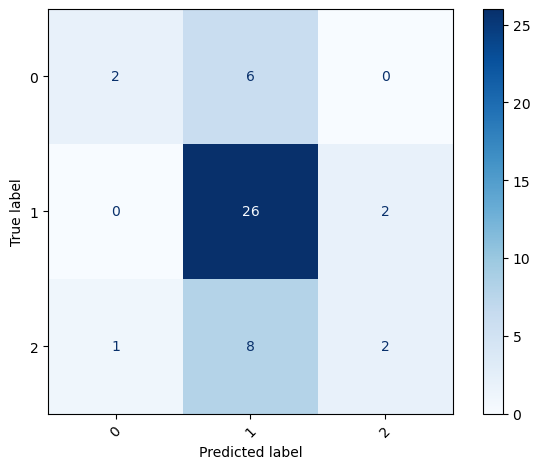

In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# AutoGluon requiere que el target esté en el DataFrame
train_val_data = X_train_val_union.copy()
train_val_data['group'] = y_train_val  # asegúrate de que 'group' sea el nombre de la variable target

test_data = X_test_union.copy()
test_data['group'] = y_test

# Entrenar AutoML
predictor = TabularPredictor(label='group', eval_metric='f1_weighted').fit(
    train_val_data,
    time_limit=180,  # segundos
    verbosity=2
)

# Predicciones
y_test_pred = predictor.predict(test_data)
f1 = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Score test:", f1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.tight_layout()
plt.show()

# Probabilidades
y_prob_train_esta = predictor.predict_proba(train_val_data)
y_prob_test_esta = predictor.predict_proba(test_data)

In [ ]:
import shap

best_model_name = predictor.model_best
best_model = predictor._trainer.load_model(best_model_name)
X_test_union = test_data.drop(columns=['group'])  
y_test = test_data['group']

def predict_fn(X_array):
    X_df = pd.DataFrame(X_array, columns=X_test_union.columns)
    return predictor.predict_proba(X_df).values  # output: array (n_samples x n_classes)

selected_indices = [347,316,334,245,454,461]

# Asegurarte de que esos índices están en X_test_union
X_background = X_test_union.loc[selected_indices]
# 4. Crear el KernelExplainer
explainer = shap.KernelExplainer(predict_fn, X_background)

# 5. Calcular SHAP values sobre un subconjunto de test (ej: 50 ejemplos)
X_explain = X_test_union.loc[selected_indices]  # Elegí más si tenés tiempo
shap_values = explainer.shap_values(X_explain)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import numpy as np

top_n = 5
n_samples = shap_values.shape[0]
feature_names = X_test_union.columns

# Extraer movimientos base (ej: "Rodilla" de "Rodilla x eje_y")
def extract_movement(col_name):
    return col_name.split(' x ')[0] if ' x ' in col_name else col_name

movement_names = [extract_movement(f) for f in feature_names]

top_movements_esta = []

for i,e in zip(selected_indices,range(n_samples)):
    pred_class = y_test_pred.loc[i]  # clase predicha para ese paciente
    shap_vector = shap_values[e, :, pred_class]  # vector de SHAP para la clase predicha

    df = pd.DataFrame({
        'feature': feature_names,
        'movement': movement_names,
        'shap_value': shap_vector,
        'abs_shap': np.abs(shap_vector)
    })

    # Agrupar por movimiento → usar suma o media
    grouped = df.groupby('movement', as_index=False)['abs_shap'].sum()  # o .mean()

    # Top 5 movimientos más importantes
    top_5 = grouped.sort_values('abs_shap', ascending=False).head(top_n).reset_index(drop=True)

    # Guardar resultados
    top_movements_esta.append({
        'patient_index': i,
        'predicted_class': pred_class,
        'top_movements': top_5
    })

In [ ]:
import pandas as pd
import numpy as np

n_samples = shap_values.shape[0]
feature_names = X_test_union.columns

# Extraer movimientos base (ej: "Rodilla" de "Rodilla x eje_y")
def extract_movement(col_name):
    return col_name.split(' x ')[0] if ' x ' in col_name else col_name

movement_names = [extract_movement(f) for f in feature_names]

all_movements_esta = []

for i, e in zip(selected_indices, range(n_samples)):
    pred_class = y_test_pred.loc[i]  # clase predicha para ese paciente
    shap_vector = shap_values[e, :, pred_class]  # vector de SHAP para la clase predicha

    df = pd.DataFrame({
        'feature': feature_names,
        'movement': movement_names,
        'shap_value': shap_vector,
        'abs_shap': np.abs(shap_vector)
    })

    # Agrupar por movimiento → usar suma o media
    grouped = df.groupby('movement', as_index=False)['abs_shap'].sum()  # o .mean()

    # Ordenar todos los movimientos por importancia
    sorted_movements = grouped.sort_values('abs_shap', ascending=False).reset_index(drop=True)

    # Guardar resultados completos
    all_movements_esta.append({
        'patient_index': i,
        'predicted_class': pred_class,
        'all_movements': sorted_movements
    })

## PSD

In [ ]:
from scipy.signal import welch

def compute_features(signal, fs=100):  # Sampling rate updated to 100 Hz
    if len(signal)==2048:
        n=19
    else:
        n=9.5
    # (1) Power Spectral Density (PSD) using Welch's method
    freqs, psd = welch(signal, fs=fs, nperseg=len(signal)//n)  # Ajusta nperseg según el tamaño de la señal
    # Filtrar entre 1 y 19 Hz
    valid_idx = (freqs >= 1) & (freqs <= 19)
    psd_log = np.log(psd[valid_idx])  # Escalado logarítmico
    
    # (2) Segmentar la señal en 4 partes
    segment_length = len(signal) // 4
    segments = [signal[i*segment_length:(i+1)*segment_length] for i in range(4)]
    
    # Calcular estadísticas por segmento
    std_dev = [np.std(seg) for seg in segments]
    max_amp = [np.max(np.abs(seg)) for seg in segments]
    sum_energy = [np.sum(np.abs(seg)) for seg in segments]
    
    # Asegurar que solo haya 12 valores de estadísticas
    feature_vector = np.concatenate([psd_log, std_dev, max_amp, sum_energy])
    
    return feature_vector

# Aplicar la transformación a cada celda (cada celda contiene un vector)
def transform_dataframe(df):
    df_transformed = df.copy()
    for col in df.iloc[:, 1:].columns:  # Aplicar solo a columnas desde la 45 en adelante
        df_transformed[col] = df[col].apply(lambda x: compute_features(np.array(x)))
    return df_transformed

df_psd = transform_dataframe(df_series)
vector_columns = df_psd.columns[1:]
expanded_dfs = []
for col in vector_columns:
    expanded = pd.DataFrame(df_psd[col].tolist(), columns=[f'{col}_vec{i}' for i in range(31)])
    expanded_dfs.append(expanded)
df_psd = pd.concat([df_psd.iloc[:, :1]] + expanded_dfs, axis=1)


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Supongamos que tienes un DataFrame llamado df
# Separamos las características (X) y la etiqueta (y)
X = df_psd.drop(columns=['group'])
y = df_psd['group']

# Dividimos en entrenamiento y prueba
X_train = X.loc[train_idx]
X_val = X.loc[val_idx]
X_test = X.loc[test_idx]
X_train_val = X.loc[train_val_idx]
y_train = y.loc[train_idx]
y_val = y.loc[val_idx]
y_test = y.loc[test_idx]
y_train_val = y.loc[train_val_idx]

# Inicializamos el clasificador Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenamos el modelo para obtener la importancia de las características
model.fit(X_train, y_train)

# Obtenemos la importancia de las características
feature_importances = model.feature_importances_

# Ordenamos las características según la importancia (de mayor a menor)
sorted_idx = np.argsort(feature_importances)[::-1]  # Ordenamos en orden descendente

# Creamos un nuevo DataFrame con las características ordenadas por importancia
X_sorted = X_train.iloc[:, sorted_idx]

# Inicializamos la lista para almacenar el F1-score para diferentes números de características
f1_scores = []

# Número máximo de características a considerar
max_features = len(X_sorted.columns)

# Inicializamos el mejor F1-score y el número de características
best_f1_score = 0
best_n_features = 100

# A partir de las 100 características, vamos añadiendo 10 características más a la vez
X_train_selected = X_sorted.iloc[:, :100]
X_val_selected = X_val.iloc[:, sorted_idx[:100]]

# Entrenamos el modelo con las primeras 100 características
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_val_selected)
best_f1_score = f1_score(y_val, y_pred, average='weighted')
f1_scores.append(best_f1_score)

# Early stopping variables
no_improvement_counter = 0  # Contador de iteraciones sin mejora significativa
max_no_improvement = 10  # Umbral de iteraciones sin mejora
threshold_drop = 0.01  # Umbral para considerar una mejora significativa

# Ahora, vamos a agregar características de 10 en 10
for n_features in range(110, max_features + 1, 10):  # Añadimos de 10 en 10
    # Seleccionamos las primeras n características más importantes
    X_train_selected = X_sorted.iloc[:, :n_features]
    X_val_selected = X_val.iloc[:, sorted_idx[:n_features]]

    # Entrenamos el modelo con las características seleccionadas
    model.fit(X_train_selected, y_train)

    # Realizamos predicciones
    y_pred = model.predict(X_val_selected)

    # Calculamos el F1-score
    f1 = f1_score(y_val, y_pred, average='weighted')  # Usamos 'weighted' para manejar clases desbalanceadas
    f1_scores.append(f1)

    # Si el F1-score no mejora significativamente, incrementamos el contador
    if f1 - best_f1_score < threshold_drop:
        no_improvement_counter += 1
    else:
        no_improvement_counter = 0  # Reseteamos el contador si hay mejora

    # Si el contador de no mejora supera el umbral, detenemos el proceso
    if no_improvement_counter >= max_no_improvement:
        break

    # Actualizamos el mejor F1-score y el número de características si es mejor
    if f1 > best_f1_score:
        best_f1_score = f1
        best_n_features = n_features

# Resultados finales
print(f"\nEl mejor número de características seleccionadas es {best_n_features} con un F1-score de {best_f1_score:.2f}")

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso.fit(X_train, y_train)

selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_val)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_test_selected)
f1 = f1_score(y_val, y_pred, average='weighted')
selected_features = X.columns[selector.get_support()]
union_features = sorted(set(selected_features) | set(X_sorted.columns[:best_n_features]))

# Filtramos X_train y X_test usando solo las variables de la unión
X_train_union = X_train[union_features]
X_val_union = X_val[union_features]
X_train_val_union = X_train_val[union_features]
X_test_union = X_test[union_features]


El mejor número de características seleccionadas es 240 con un F1-score de 0.56


No path specified. Models will be saved in: "AutogluonModels/ag-20250507_145717"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:12 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8103
CPU Count:          8
Memory Avail:       1.27 GB / 8.00 GB (15.9%)
Disk Space Avail:   6.29 GB / 228.27 GB (2.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration

F1 Score test: 0.5763937501915058


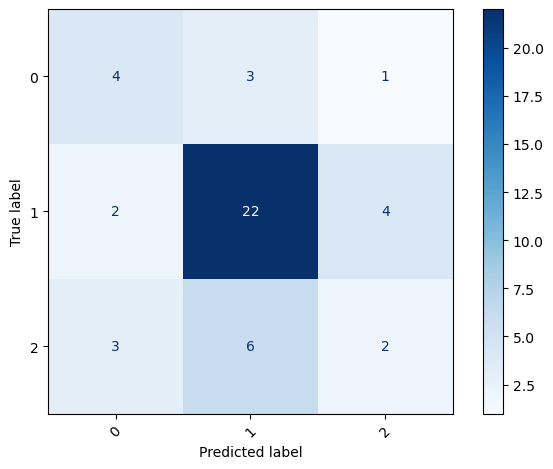

In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# AutoGluon requiere que el target esté en el DataFrame
train_val_data = X_train_val_union.copy()
train_val_data['group'] = y_train_val  # asegúrate de que 'group' sea el nombre de la variable target

test_data = X_test_union.copy()
test_data['group'] = y_test

# Entrenar AutoML
predictor = TabularPredictor(label='group', eval_metric='f1_weighted').fit(
    train_val_data,
    time_limit=180,  # segundos
    verbosity=2
)

# Predicciones
y_test_pred = predictor.predict(test_data)
f1 = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Score test:", f1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.tight_layout()
plt.show()

# Probabilidades
y_prob_train_psd = predictor.predict_proba(train_val_data)
y_prob_test_psd = predictor.predict_proba(test_data)

In [ ]:
import shap

best_model_name = predictor.model_best
best_model = predictor._trainer.load_model(best_model_name)
X_test_union = test_data.drop(columns=['group'])  
y_test = test_data['group']

def predict_fn(X_array):
    X_df = pd.DataFrame(X_array, columns=X_test_union.columns)
    return predictor.predict_proba(X_df).values  # output: array (n_samples x n_classes)

selected_indices = [347,316,334,245,454,461]

# Asegurarte de que esos índices están en X_test_union
X_background = X_test_union.loc[selected_indices]# 4. Crear el KernelExplainer
explainer = shap.KernelExplainer(predict_fn, X_background)

# 5. Calcular SHAP values sobre un subconjunto de test (ej: 50 ejemplos)
X_explain = X_test_union.loc[selected_indices]  # Elegí más si tenés tiempo
shap_values = explainer.shap_values(X_explain)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import numpy as np

top_n = 5
n_samples = shap_values.shape[0]
feature_names = X_test_union.columns

# Extraer movimientos base (ej: "Rodilla" de "Rodilla x eje_y")
def extract_movement(col_name):
    return col_name.split(' x ')[0] if ' x ' in col_name else col_name

movement_names = [extract_movement(f) for f in feature_names]

top_movements_psd = []

for i,e in zip(selected_indices,range(n_samples)):
    pred_class = y_test_pred.loc[i]  # clase predicha para ese paciente
    shap_vector = shap_values[e, :, pred_class]  # vector de SHAP para la clase predicha

    df = pd.DataFrame({
        'feature': feature_names,
        'movement': movement_names,
        'shap_value': shap_vector,
        'abs_shap': np.abs(shap_vector)
    })

    # Agrupar por movimiento → usar suma o media
    grouped = df.groupby('movement', as_index=False)['abs_shap'].sum()  # o .mean()

    # Top 5 movimientos más importantes
    top_5 = grouped.sort_values('abs_shap', ascending=False).head(top_n).reset_index(drop=True)

    # Guardar resultados
    top_movements_psd.append({
        'patient_index': i,
        'predicted_class': pred_class,
        'top_movements': top_5
    })

In [ ]:
import pandas as pd
import numpy as np

n_samples = shap_values.shape[0]
feature_names = X_test_union.columns

# Extraer movimientos base (ej: "Rodilla" de "Rodilla x eje_y")
def extract_movement(col_name):
    return col_name.split(' x ')[0] if ' x ' in col_name else col_name

movement_names = [extract_movement(f) for f in feature_names]

all_movements_psd = []

for i, e in zip(selected_indices, range(n_samples)):
    pred_class = y_test_pred.loc[i]  # clase predicha para ese paciente
    shap_vector = shap_values[e, :, pred_class]  # vector de SHAP para la clase predicha

    df = pd.DataFrame({
        'feature': feature_names,
        'movement': movement_names,
        'shap_value': shap_vector,
        'abs_shap': np.abs(shap_vector)
    })

    # Agrupar por movimiento → usar suma o media
    grouped = df.groupby('movement', as_index=False)['abs_shap'].sum()  # o .mean()

    # Ordenar todos los movimientos por importancia
    sorted_movements = grouped.sort_values('abs_shap', ascending=False).reset_index(drop=True)

    # Guardar resultados completos
    all_movements_psd.append({
        'patient_index': i,
        'predicted_class': pred_class,
        'all_movements': sorted_movements
    })

## STACKING

### Stacking Logistic Regression

📊 F1-score del stacking: 0.687
🚀 ROC-AUC (OVR): 0.804


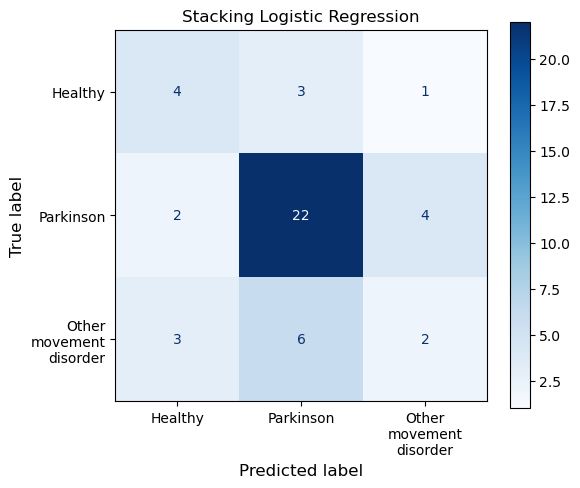

F1 con decisión coste-sensitiva: 0.6894586894586895


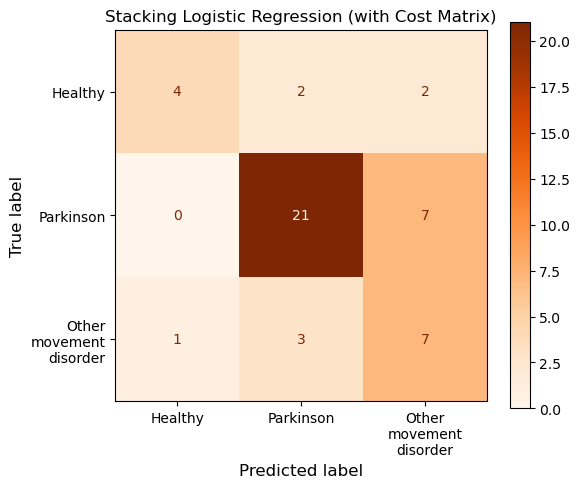

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Concatenar probabilidades del TRAIN
X_stack_train = np.hstack([y_prob_train_psd, y_prob_train_cues,y_prob_train_esta,y_prob_train_boss])
X_stack_test = np.hstack([y_prob_test_psd, y_prob_test_cues,y_prob_test_esta,y_prob_test_boss])

# 3. Entrenar el meta-modelo
meta_model = LogisticRegression(max_iter=2000, multi_class='multinomial', class_weight='balanced')
meta_model.fit(X_stack_train, y_train_val)

# 4. Evaluar sobre el TEST
y_pred_meta = meta_model.predict(X_stack_test)
f1_meta = f1_score(y_test, y_pred_meta, average='weighted')
y_prob_meta = meta_model.predict_proba(X_stack_test)

print(f"📊 F1-score del stacking: {f1_meta:.3f}")

# 5. ROC-AUC
auc_meta = roc_auc_score(y_test, y_prob_meta, multi_class='ovr')
print(f"🚀 ROC-AUC (OVR): {auc_meta:.3f}")

# 6. Matriz de Confusión
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Etiquetas más legibles
labels = ["Healthy", "Parkinson", "Other\nmovement\ndisorder"]

# Graficar matriz de confusión con mejoras
fig, ax = plt.subplots(figsize=(6, 5))  # Ajustar tamaño
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, colorbar=True)

# Mejoras estéticas
plt.title("Stacking Logistic Regression", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.tight_layout()
plt.grid(False)  
plt.show()

import numpy as np

C = np.array([
    [ 0,  1,  1],   # HC → {HC,PD,DD}
    [10,  0,  5],   # PD → {HC,PD,DD}
    [ 10,  5,  0],   # DD → {HC,PD,DD}
])

# y_prob_meta: salida de meta_model.predict_proba(X_stack_test)
# Cada fila p = [p(HC), p(PD), p(DD)]

# 1) Para cada muestra i, cost_expected[i, j] = Σ_k p_i[k] * C[k, j]
cost_expected = y_prob_meta.dot(C)

# 2) Predicción coste-mínimo: escogemos la clase j que minimiza el coste esperado
y_pred_cost = np.argmin(cost_expected, axis=1)

# 3) Ahora evaluamos con esa predicción
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

f1_cost = f1_score(y_test, y_pred_cost, average='weighted')
print("F1 con decisión coste-sensitiva:", f1_cost)

# Etiquetas legibles
labels = ["Healthy", "Parkinson", "Other\nmovement\ndisorder"]

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_cost, labels=[0, 1, 2])
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Oranges', ax=ax, colorbar=True)

# Mejoras visuales
plt.title("Stacking Logistic Regression (with Cost Matrix)", fontsize=12)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.show()

### Stacking MLPClassifier

F1-score (standard): 0.6891725768321513
ROC-AUC (OVR): 0.8168476260581524


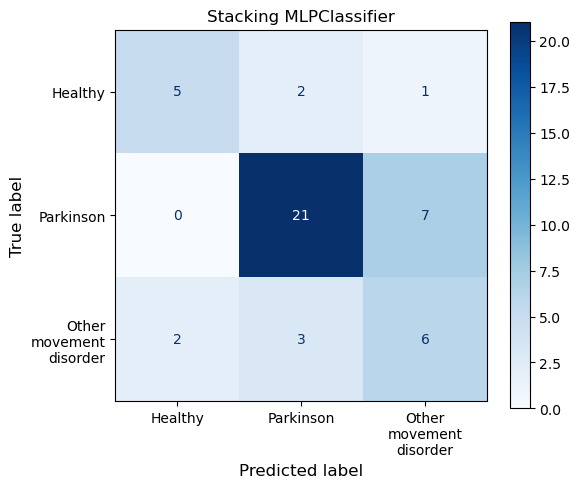

F1 con decisión coste-sensitiva: 0.66548463356974


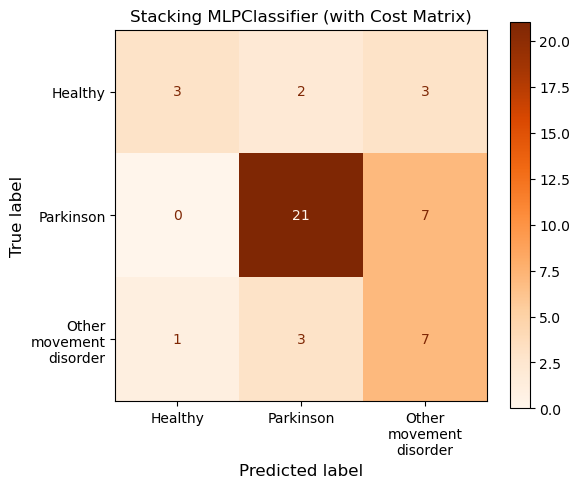

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 1. Preparamos X_stack_train / X_stack_test
X_stack_train = np.hstack([y_prob_train_psd, y_prob_train_cues, y_prob_train_esta, y_prob_train_boss])
X_stack_test  = np.hstack([y_prob_test_psd,  y_prob_test_cues,  y_prob_test_esta,  y_prob_test_boss])

# 2. Definimos un MLPClassifier como meta-modelo
meta_model = MLPClassifier(
    hidden_layer_sizes=(50,25),  # dos capas ocultas de 50 y 25 neuronas
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=7
)

# 3. Entrenamos el meta-modelo
meta_model.fit(X_stack_train, y_train_val)

# 4. Predecimos probabilidades y etiquetas (decisión estándar)
y_prob_meta = meta_model.predict_proba(X_stack_test)
y_pred_meta = np.argmax(y_prob_meta, axis=1)

# 5. Evaluación estándar
print("F1-score (standard):", f1_score(y_test, y_pred_meta, average='weighted'))
print("ROC-AUC (OVR):", roc_auc_score(y_test, y_prob_meta, multi_class='ovr'))

# Etiquetas legibles
labels = ["Healthy", "Parkinson", "Other\nmovement\ndisorder"]

# Matriz de confusión con estilo mejorado
cm = confusion_matrix(y_test, y_pred_meta)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, colorbar=True)

# Título y ejes
plt.title("Stacking MLPClassifier", fontsize=12)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.show()

# 6. Decisión coste-sensitiva
C = np.array([
    [ 0,  1,  1],   # True HC → predict [HC, PD, DD]
    [10,  0,  5],   # True PD → predict [HC, PD, DD]
    [10,  5,  0],   # True DD → predict [HC, PD, DD]
])

# Coste esperado para cada muestra y cada clase
cost_expected = y_prob_meta.dot(C)

# Elegimos la clase que minimiza el coste esperado
y_pred_cost = np.argmin(cost_expected, axis=1)

# 3) Evaluamos bajo la decisión coste-sensitiva
f1_cost = f1_score(y_test, y_pred_cost, average='weighted')
print("F1 con decisión coste-sensitiva:", f1_cost)

# Etiquetas legibles
labels = ["Healthy", "Parkinson", "Other\nmovement\ndisorder"]

# Matriz de confusión para decisión coste-sensitiva
cm_cost = confusion_matrix(y_test, y_pred_cost, labels=[0, 1, 2])
fig, ax = plt.subplots(figsize=(6, 5))
disp_cost = ConfusionMatrixDisplay(confusion_matrix=cm_cost, display_labels=labels)
disp_cost.plot(cmap='Oranges', ax=ax, colorbar=True)

# Título y mejoras visuales
plt.title("Stacking MLPClassifier (with Cost Matrix)", fontsize=12)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.show()

### Stacking RandomForestClassifier

📊 F1-score (standard): 0.723
🚀 ROC-AUC (OVR): 0.77


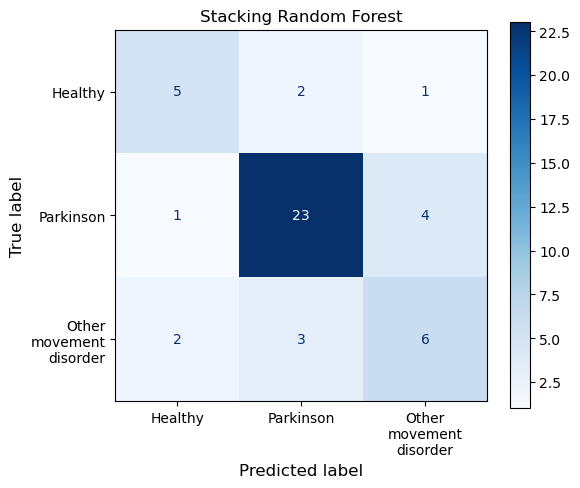

📊 F1-score (cost-sensitive): 0.673


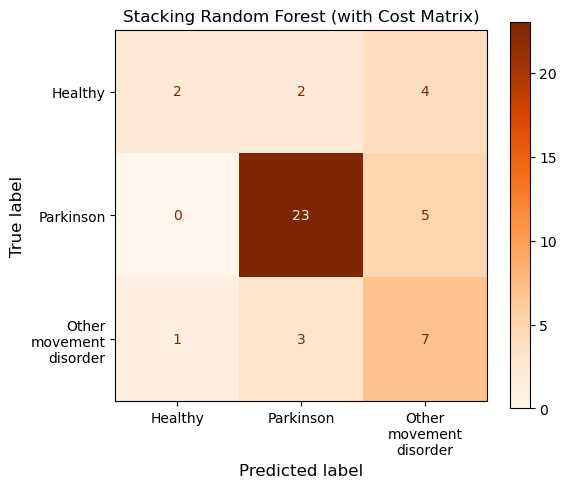

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 1. Preparamos X_stack_train / X_stack_test
X_stack_train = np.hstack([y_prob_train_psd, y_prob_train_cues, y_prob_train_esta, y_prob_train_boss])
X_stack_test  = np.hstack([y_prob_test_psd,  y_prob_test_cues,  y_prob_test_esta,  y_prob_test_boss])

# 2. Meta-modelo Random Forest
meta_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=7,
    class_weight=None
)

# 3. Entrenamiento
meta_model.fit(X_stack_train, y_train_val)

# 4. Predicción estándar
y_prob_meta = meta_model.predict_proba(X_stack_test)
y_pred_meta = np.argmax(y_prob_meta, axis=1)

# 5. Evaluación estándar
f1_standard = f1_score(y_test, y_pred_meta, average='weighted')
auc_standard = roc_auc_score(y_test, y_prob_meta, multi_class='ovr')
print("📊 F1-score (standard):", round(f1_standard, 3))
print("🚀 ROC-AUC (OVR):", round(auc_standard, 3))

# Etiquetas legibles
labels = ["Healthy", "Parkinson", "Other\nmovement\ndisorder"]

# Matriz estándar
cm = confusion_matrix(y_test, y_pred_meta, labels=[0, 1, 2])
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.title("Stacking Random Forest", fontsize=12)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.show()

# 6. Decisión coste-sensitiva
C = np.array([
    [ 0,  1,  1],   # True HC → predict [HC, PD, DD]
    [10,  0,  5],   # True PD → predict [HC, PD, DD]
    [10,  5,  0],   # True DD → predict [HC, PD, DD]
])
cost_expected = y_prob_meta.dot(C)
y_pred_cost = np.argmin(cost_expected, axis=1)

# 7. Evaluación coste-sensitiva
f1_cost = f1_score(y_test, y_pred_cost, average='weighted')
print("📊 F1-score (cost-sensitive):", round(f1_cost, 3))

cm2 = confusion_matrix(y_test, y_pred_cost, labels=[0, 1, 2])
fig, ax = plt.subplots(figsize=(6, 5))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)
disp2.plot(cmap='Oranges', ax=ax, colorbar=True)
plt.title("Stacking Random Forest (with Cost Matrix)", fontsize=12)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.show()

### Stacking XGBClassifier

F1-score stacking XGB: 0.7428144830160507
ROC-AUC (OVR): 0.8012283768862716


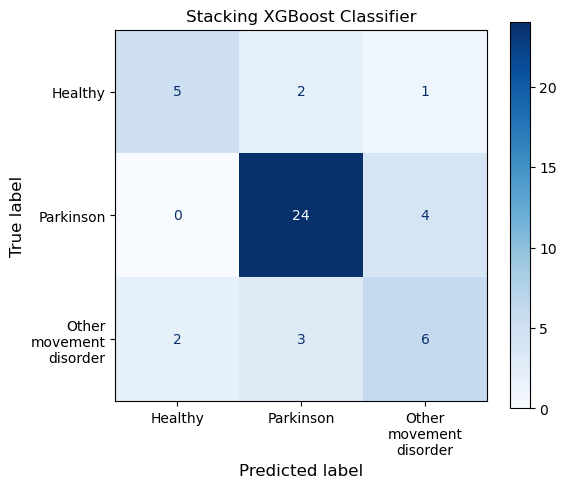

F1 con decisión coste-sensitiva: 0.6859894617488163


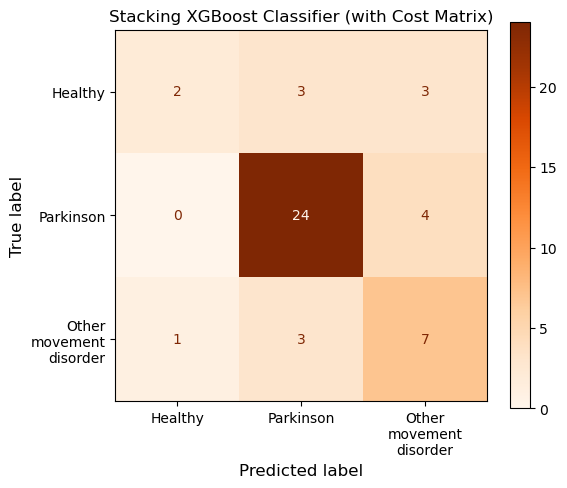

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Preparamos X_stack_train / X_stack_test
X_stack_train = np.hstack([y_prob_train_psd, y_prob_train_cues,y_prob_train_esta,y_prob_train_boss])
X_stack_test = np.hstack([y_prob_test_psd, y_prob_test_cues,y_prob_test_esta,y_prob_test_boss])

# 2. Definimos un XGBClassifier multinomial
meta_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=7
)

# 3. Entrenamos el meta-modelo
meta_model.fit(X_stack_train, y_train_val)

# 4. Predecimos probabilidades
y_prob_meta = meta_model.predict_proba(X_stack_test)

# 5. Decisión estándar (mayor probabilidad)
y_pred_meta = np.argmax(y_prob_meta, axis=1)
print("F1-score stacking XGB:", f1_score(y_test, y_pred_meta, average='weighted'))
print("ROC-AUC (OVR):", roc_auc_score(y_test, y_prob_meta, multi_class='ovr'))

# Etiquetas legibles
labels = ["Healthy", "Parkinson", "Other\nmovement\ndisorder"]

# Matriz de confusión con estilo mejorado
cm = confusion_matrix(y_test, y_pred_meta)
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, colorbar=True)

# Título y ejes
plt.title("Stacking XGBoost Classifier", fontsize=12)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.show()

# -- Ahora la decisión coste-sensitiva --

# Definimos la matriz de costes C[i,j]: coste de predecir j cuando la verdadera es i
C = np.array([
    [ 0,  1,  1],   # True HC → predict [HC, PD, DD]
    [10,  0,  5],   # True PD → predict [HC, PD, DD]
    [ 10,  5,  0],   # True DD → predict [HC, PD, DD]
])

# 1) Coste esperado para cada muestra i y cada predicción j: Σ_k p_i[k] * C[k,j]
cost_expected = y_prob_meta.dot(C)

# 2) Elegimos la clase j que minimiza el coste esperado
y_pred_cost = np.argmin(cost_expected, axis=1)

# 3) Evaluamos bajo la decisión coste-sensitiva
f1_cost = f1_score(y_test, y_pred_cost, average='weighted')
print("F1 con decisión coste-sensitiva:", f1_cost)

# Etiquetas legibles
labels = ["Healthy", "Parkinson", "Other\nmovement\ndisorder"]

# Matriz de confusión para decisión coste-sensitiva
cm_cost = confusion_matrix(y_test, y_pred_cost, labels=[0, 1, 2])
fig, ax = plt.subplots(figsize=(6, 5))
disp_cost = ConfusionMatrixDisplay(confusion_matrix=cm_cost, display_labels=labels)
disp_cost.plot(cmap='Oranges', ax=ax, colorbar=True)

# Título y mejoras visuales
plt.title("Stacking XGBoost Classifier (with Cost Matrix)", fontsize=12)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.show()

### Importancia de modelos
ejecutar mejor modelo el ult para que var meta_model acceda a él

In [ ]:
#Obtener los coeficientes del modelo (forma: n_clases x n_features)
import shap
explainer = shap.Explainer(meta_model, X_stack_train)
shap_values = explainer(X_stack_train)
shap_values.shape
import numpy as np

# Extraer los valores numéricos del objeto SHAP
shap_array = shap_values.values  # shape: (422, 12, 3)

# Calcular la media sobre las muestras (eje 0)
mean_shap_per_class = np.mean(shap_array, axis=0).T  # shape: (3, 12)
coef = mean_shap_per_class  # shape (n_classes, 6) si tienes 2 modelos y 3 clases

# Sumar valor absoluto por conjunto de entrada (psd vs cues)
psd_importance = np.mean(np.abs(coef[:, :3]), axis=0)  # columnas 0 a 2
cues_importance = np.mean(np.abs(coef[:, 3:6]), axis=0)  # columnas 3 a 5
esta_importance = np.mean(np.abs(coef[:, 6:9]), axis=0)  # columnas 3 a 5
boss_importance = np.mean(np.abs(coef[:, 9:]), axis=0)  # columnas 3 a 5


# Promedio total por fuente
total_psd_importance = np.mean(psd_importance)
total_cues_importance = np.mean(cues_importance)
total_esta_importance = np.mean(esta_importance)
total_boss_importance = np.mean(boss_importance)


# Mostrar
print("🔍 Importancia media asignada por el meta-modelo:")
print(f" PSD:  {total_psd_importance:.4f}")
print(f" ESTA: {total_esta_importance:.4f}")
print(f" CUES: {total_cues_importance:.4f}")
print(f" BOSS: {total_boss_importance:.4f}")

total_sum = total_psd_importance + total_cues_importance + total_esta_importance + total_boss_importance

# Calcular porcentaje sobre 100
psd_percent = 100 * total_psd_importance / total_sum
cues_percent = 100 * total_cues_importance / total_sum
esta_percent = 100 * total_esta_importance / total_sum
boss_percent = 100 * total_boss_importance / total_sum

# Mostrar
print("📊 Importancia relativa por conjunto de entrada (%):")
print(f" PSD:  {psd_percent:.2f}%")
print(f" ESTA: {esta_percent:.2f}%")
print(f" CUES: {cues_percent:.2f}%")
print(f" BOSS: {boss_percent:.2f}%")

🔍 Importancia media asignada por el meta-modelo:
 PSD:  0.0083
 ESTA: 0.0284
 CUES: 0.0116
 BOSS: 0.0490
📊 Importancia relativa por conjunto de entrada (%):
 PSD:  8.54%
 ESTA: 29.16%
 CUES: 11.90%
 BOSS: 50.40%


In [ ]:
import numpy as np
import pandas as pd

# Coeficientes del modelo (shape: n_clases x n_features)
coef = mean_shap_per_class  # shape (3, 6)

# Separar por bloques: PSD (col 0-2), CUES (col 3-5)
# Calculamos importancia como valor absoluto medio por bloque, por clase
psd_importance_per_class = np.mean(np.abs(coef[:, :3]), axis=1)   # shape: (3,)
cues_importance_per_class = np.mean(np.abs(coef[:, 3:6]), axis=1)  # shape: (3,)
esta_importance_per_class = np.mean(np.abs(coef[:, 6:9]), axis=1)  # shape: (3,)
boss_importance_per_class = np.mean(np.abs(coef[:, 9:]), axis=1)  # shape: (3,)


# Crear DataFrame para visualización
importance_df = pd.DataFrame({
    'Clase': [0, 1, 2],
    'PSD_importancia': psd_importance_per_class,
    'CUES_importancia': cues_importance_per_class,
    'BOSS_importancia': boss_importance_per_class,
    'ESTA_importancia': esta_importance_per_class

})

print("📊 Importancia media por clase y por fuente:")
importance_df

📊 Importancia media por clase y por fuente:


,Clase,PSD_importancia,CUES_importancia,BOSS_importancia,ESTA_importancia
0,0,0.005734,0.013398,0.039185,0.057167
1,1,0.007953,0.013964,0.086663,0.020923
2,2,0.011241,0.007362,0.021235,0.007012


In [ ]:
import pandas as pd

# Mapeo del nombre del modelo a su columna en importance_df
modelo_columna = {
    'PSD': 'PSD_importancia',
    'BOSS': 'BOSS_importancia',
    'CUES': 'CUES_importancia',
    'ESTA': 'ESTA_importancia'
}

# Diccionario con los top movements/features por modelo
all_movements_dict = {
    'PSD': all_movements_psd,
    'BOSS': all_movements_boss,
    'CUES': all_features_cues,  # <- nombre ya corregido
    'ESTA': all_movements_esta
}

# Lista para almacenar los resultados
ponderaciones_pacientes = []

# Se asume que todas las listas tienen la misma longitud y orden
for idx in range(len(all_movements_psd)):
    patient_index = all_movements_psd[idx]['patient_index']
    predicted_class = all_movements_psd[idx]['predicted_class']
    
    total_importance = pd.DataFrame()

    for modelo, modelo_data in all_movements_dict.items():
        entry = modelo_data[idx]
        peso_modelo = importance_df.loc[predicted_class, modelo_columna[modelo]]

        # Adaptar nombres de columna según el modelo
        if modelo == 'CUES':
            df = entry['all_features'].copy()
            df.rename(columns={'feature': 'name', 'shap_value': 'shap'}, inplace=True)
        else:
            df = entry['all_movements'].copy()
            df.rename(columns={'movement': 'name', 'abs_shap': 'shap'}, inplace=True)
        
        df['ponderada'] = df['shap'] * peso_modelo
        df['name'] = df['name'].astype(str)
        total_importance = pd.concat([total_importance, df[['name', 'ponderada']]])

    # Agrupar por nombre (feature o movimiento) y sumar su ponderación
    total_importance = total_importance.groupby('name', as_index=False).sum()

    # Obtener el top 5
    top5 = total_importance.sort_values(by='ponderada', ascending=False).head(5)
    top5['patient_index'] = patient_index
    top5['predicted_class'] = predicted_class

    ponderaciones_pacientes.append(top5)

# Unir todo en un único DataFrame
final_df = pd.concat(ponderaciones_pacientes, ignore_index=True)

In [ ]:
print(min_val)
print(max_val)

NameError: name 'min_val' is not defined

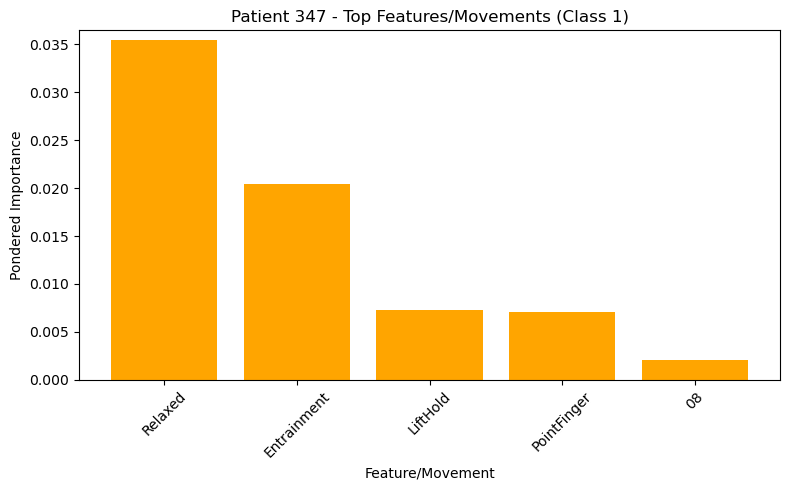

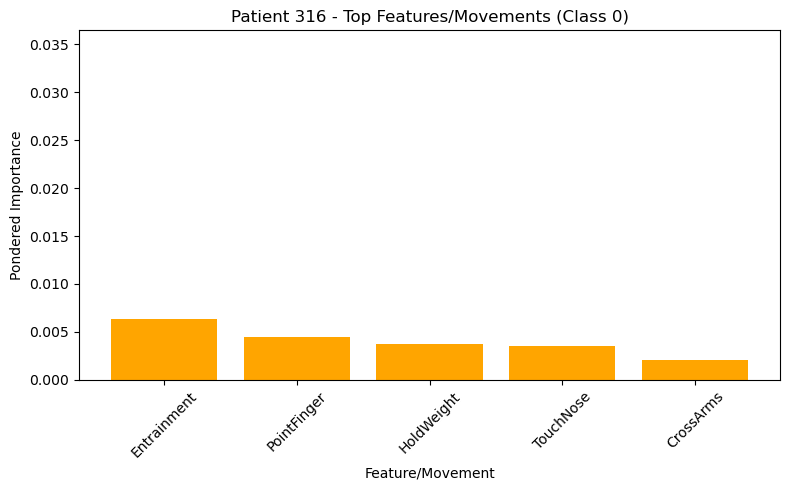

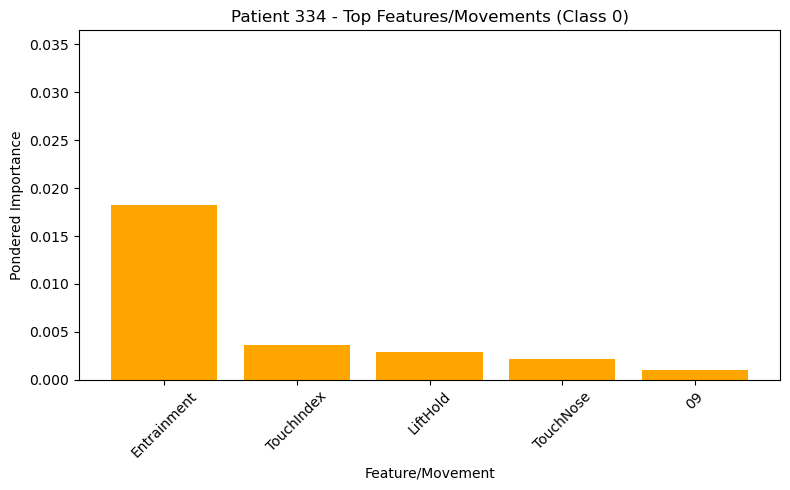

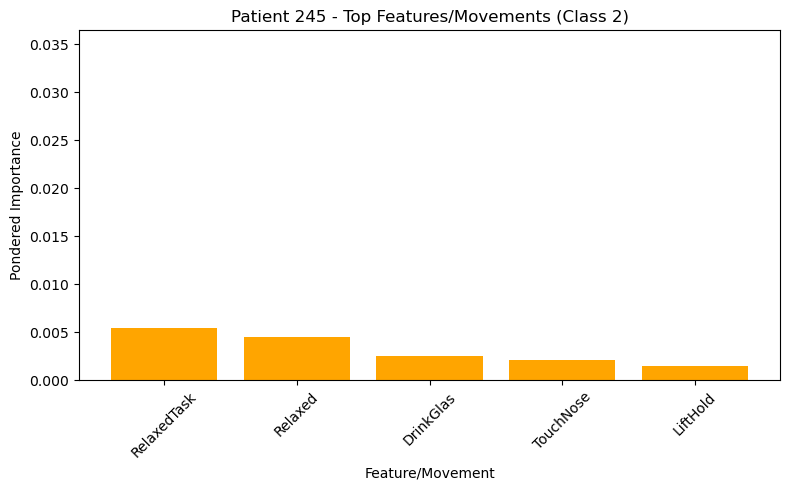

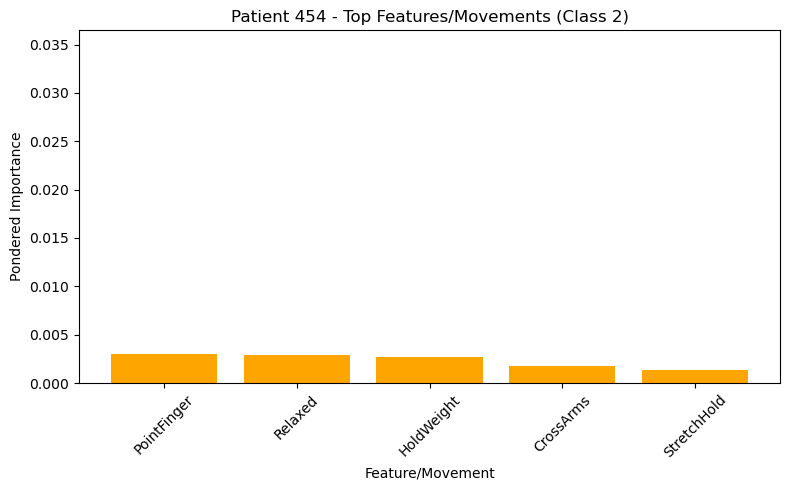

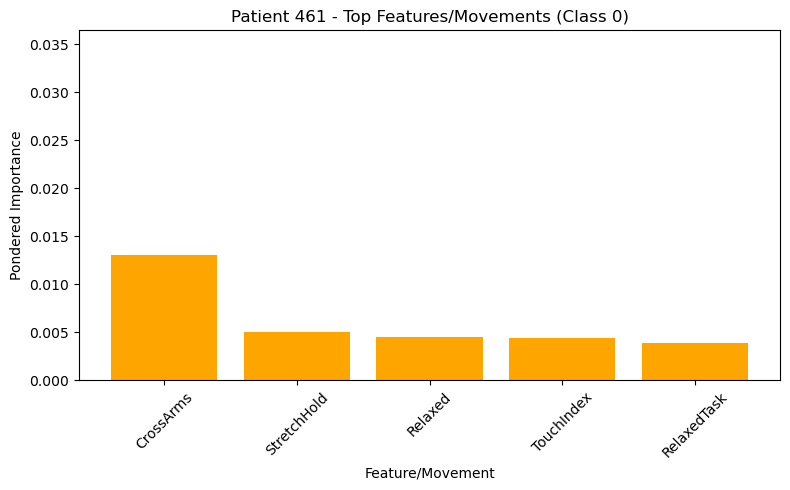

In [ ]:
import matplotlib.pyplot as plt

# Valor máximo global ya calculado
max_global = final_df['ponderada'].max() + 0.001

# Graficar para cada paciente
for patient in final_df['patient_index'].unique():
    data = final_df[final_df['patient_index'] == patient]
    
    plt.figure(figsize=(8, 5))
    plt.bar(data['name'], data['ponderada'], color='orange')
    
    plt.title(f'Patient {patient} - Top Features/Movements (Class {data["predicted_class"].iloc[0]})')
    plt.xlabel('Feature/Movement')
    plt.ylabel('Pondered Importance')
    plt.ylim(0, max_global)  # Fijar eje y
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:

# Supongamos que tienes estos objetos después del entrenamiento
# model_boss, model_psd, model_stats = modelos finales
# transformer_boss, transformer_psd, transformer_stats = pipelines
# important_features = lista de variables seleccionadas

to_save = {
    "model_boss": model_boss,
    "transformer_boss": transformer_boss,
    "model_psd": model_psd,
    "transformer_psd": transformer_psd,
    "model_stats": model_stats,
    "transformer_stats": transformer_stats,
    "important_features": important_features
}

with open("final_pipeline.pkl", "wb") as f:
    pickle.dump(to_save, f)

In [ ]:
import pickle
import pandas as pd

# Cargar el pipeline y modelos
with open("final_pipeline.pkl", "rb") as f:
    saved = pickle.load(f)

# Cargar nuevo paciente
nuevo_paciente = pd.read_csv("nuevo_paciente.csv")  # o como sea tu entrada

# Aplicar las transformaciones
X_boss = saved['transformer_boss'].transform(nuevo_paciente)
X_psd = saved['transformer_psd'].transform(nuevo_paciente)
X_stats = saved['transformer_stats'].transform(nuevo_paciente)

# Filtrar solo las variables importantes si es necesario
X_boss = X_boss[saved['important_features']]
# Igual para los otros

# Realizar predicción
pred_boss = saved['model_boss'].predict(X_boss)
# pred_psd = ...
# pred_stats = ...
